The goal of this notebook is to perform optimizations on all Microsim models of interest to the Kaiser population projects.
We start with the models that can produce death outcomes and then proceed to outcome models that are not so likely associated with mortality.

In [1]:
import numpy as np
import pandas as pd
import os
import importlib.util
from scipy import optimize
import matplotlib.pyplot as plt

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

pd.set_option('future.no_silent_downcasting', True) 

from microsim.outcome import OutcomeType
from microsim.regression_model import RegressionModel
from microsim.modality import Modality
from microsim.population_factory import PopulationFactory
from microsim.data_loader import load_model_spec
from microsim.ascvd_outcome_model import ASCVDOutcomeModel
from microsim.dementia_model_repository import DementiaModelRepository
from microsim.dementia_model import DementiaModel
from microsim.cv_model import CVModelMale, CVModelFemale
from microsim.non_cv_death_model import NonCVDeathModel
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel
from microsim.outcome import Outcome, OutcomeType

In [2]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
ratesRef = {"stroke": strokeRatesRef, "death": deathRatesRef, "dementia": dementiaRatesRef}

In [3]:
def get_rates_from_models(x):
    '''This function will change as we move on to the different parts of the model optimization.'''
    
    ascvdInterceptChange = x[0]
    dementiaLinearChange = 0 #at this step we will not optimize at all dementia, we will leave it at the NHANES default
    dementiaQuadraticChange = 0 
    nonCVDeathInterceptChange = x[1]
    
    #I was not able to make this to work, I am unsure why.
    #For now, I am implementing the CV male and female models that will be optimized using the scd term but
    #at the implementation on the microsim code I will move this to the ASCVDOutcomeModel class.
    #So the way it is implemented here will be different than the Microsim code but the results should be the same.
    
#     class ASCVDOutcomeModelKaiser(ASCVDOutcomeModel):
#         def __init__(self, regression_model, tot_chol_hdl_ratio, black_race_x_tot_chol_hdl_ratio):
#             super().__init__(regression_model, tot_chol_hdl_ratio, black_race_x_tot_chol_hdl_ratio)
            
#         def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
#             lp = super().super().estimate_next_risk(person) 
#             lp += self.get_intercept_change_for_person(person, interceptChangeFor1bpMedsAdded)
#             lp += self.get_scd_term(person)
#             print(lp)
#             return lp
        
#         def get_scd_term(self, person):
#             '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
#             #scdTerm = ascvdInterceptChange
#             scdTerm = 10000000000
#             window = len(person._age)
#             severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
#             severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
#             if person._outcomes[OutcomeType.WMH][0][1].sbi:
#                 if person._modality == Modality.MR.value:
#                     if person._age[-1] < 65:
#                         if window ==1:
#                             scdTerm += np.log(4.75)
#                         elif window <=3:
#                             scdTerm += np.log(3.45)
#                         elif window <=5:
#                             scdTerm += np.log(2.18)
#                         elif window >5:
#                             scdTerm += np.log(1.99)
#                     else:
#                         if window ==1:
#                             scdTerm += np.log(3.)
#                         elif window <=3:
#                             scdTerm += np.log(2.63)
#                         elif window <=5:
#                             scdTerm += np.log(1.61)
#                         elif window >5:
#                             scdTerm += np.log(1.43)
#                 elif person._modality == Modality.CT.value:
#                     if person._age[-1] < 65:
#                         if window ==1:
#                             scdTerm += np.log(3.91)
#                         elif window <=3:
#                             scdTerm += np.log(2.34)
#                         elif window <=5:
#                             scdTerm += np.log(2.33)
#                         elif window >5:
#                             scdTerm += np.log(2.01)
#                     else:
#                         if window ==1:
#                             scdTerm += np.log(2.47)
#                         elif window <=3:
#                             scdTerm += np.log(1.79)
#                         elif window <=5:
#                             scdTerm += np.log(1.71)
#                         elif window >5:
#                             scdTerm += np.log(1.44)
#             if person._outcomes[OutcomeType.WMH][0][1].wmh:
#                 if window ==1:
#                     td = 1.
#                     #        lp += np.log(1.89)
#                 elif window <=3:
#                     #td = 1.9/1.89
#                     td = np.log(1.9)/np.log(1.89)
#                     #        lp += np.log(1.90)
#                 elif window <=5:
#                     #td = 1.73/1.89
#                     td = np.log(1.73)/np.log(1.89)
#                     #        lp += np.log(1.73)
#                 elif window >5:
#                     #td = 1.56/1.89
#                     td = np.log(1.56)/np.log(1.89)
#                     #        lp += np.log(1.56)
#                 td = 1 #let's see the best we can do without time dependency
#                 if person._modality == Modality.MR.value:
#                     if severityUnknown:
#                         scdTerm += np.log(td*1.89)
#                     elif severity == WMHSeverity.MILD:
#                         scdTerm += np.log(td*1.51)
#                     elif severity == WMHSeverity.MODERATE:
#                         scdTerm += np.log(td*2.33)
#                     elif severity == WMHSeverity.SEVERE:
#                         scdTerm += np.log(td*2.65)
#                     elif severity == WMHSeverity.NO:
#                         scdTerm += np.log(td*1.)
#                 elif person._modality == Modality.CT.value:
#                     if severityUnknown:
#                         scdTerm += np.log(td*2.40)
#                     elif severity == WMHSeverity.MILD:
#                         scdTerm += np.log(td*2.15)
#                     elif severity == WMHSeverity.MODERATE:
#                         scdTerm += np.log(td*3.01)
#                     elif severity == WMHSeverity.SEVERE:
#                         scdTerm += np.log(td*3.23)
#                     elif severity == WMHSeverity.NO:
#                         scdTerm += np.log(td*1.39)
#             return scdTerm

    # module1 = importlib.import_module("microsim.cv_model")
    # module1 = importlib.import_module("microsim.ascvd_outcome_model")
    # setattr(module1, "ASCVDOutcomeModel", ASCVDOutcomeModelKaiser)
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [4]:
def get_loss_from_rates(rates, step=None):
    if step is None: #include all rates
        return sum([(rates[outcome][group] - ratesRef[outcome][group])**2  
                for outcome in ["stroke","dementia","death"] 
                for group in rates[outcome].keys() ])
    elif step==1: #stroke, death only, no SBI and no WMH only
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["stroke","death"]  
                      for group in [0,4]])  # only for no SBI and no WMH
    #elif step==2: #stroke and death only, ct sbi only
    #    return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
    #                  for outcome in ["stroke","death"]  
    #                  for group in [1]]) 
    elif step==2: #stroke only, ct sbi only
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["stroke"]  
                      for group in [1]]) 
    #elif step==3: #stroke and death only, mri sbi only
    #    return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
    #                  for outcome in ["stroke","death"]  
    #                  for group in [5]]) 
    elif step==3: #stroke only, ct wmh only
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["stroke"]  
                      for group in [2]]) 
    elif step==4: #death only, ct
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["death"]  
                      for group in [1,2,3]]) 
    elif step==5: # stroke only, mri sbi
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["stroke"]  
                      for group in [5]]) 
    elif step==6: # death only, mri
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["death"]  
                      for group in [5,6,7]]) 
    elif step==7: # dementia only
        return sum([ (rates[outcome][group] - ratesRef[outcome][group])**2 
                      for outcome in ["dementia"]  
                      for group in [0, 1,2,3,4, 5,6, 7]])

In [5]:
def get_loss_from_models(x, step=None):
    '''First we get the outcome rates from the models and then we get the loss from the rates.'''
    rates = get_rates_from_models(x)
    return get_loss_from_rates(rates, step=step)

In [6]:
%%time
#step 1, no sbi & no wmh, stroke and death
result = optimize.brute(get_loss_from_models, [( 0.87-0.4,    0.87+0.3), (0.1, 0.6)], 
                        Ns=5, args=(1), finish=None, workers=1, full_output=True ) 

CPU times: user 11h 45min 31s, sys: 13min 43s, total: 11h 59min 15s
Wall time: 11h 55min 34s


In [7]:
result[0]

array([0.645, 0.35 ])

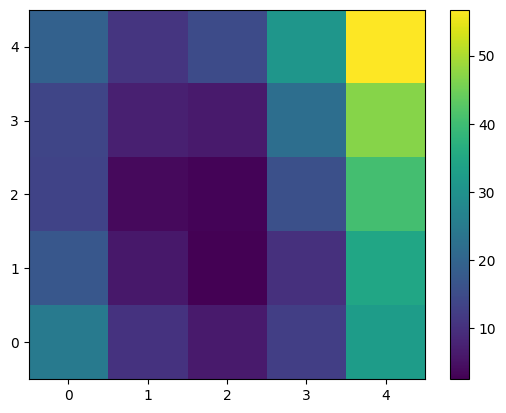

In [8]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [9]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [10]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           16.4
    CT WMD       28.5 ( 27.7 - 29.3 )           19.8
   CT BOTH       47.4 ( 44.5 - 50.5 )           35.0
   CT NONE        8.2 (  8.0 -  8.4 )            7.0
   MRI SBI       31.2 ( 28.0 - 34.6 )           14.2
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.1
  MRI BOTH       34.5 ( 30.6 - 38.7 )           27.2
  MRI NONE        4.8 (  4.5 -  5.2 )            5.2


In [11]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.9
    CT WMD       37.7 ( 36.7 - 38.7 )           10.8
   CT BOTH       51.6 ( 48.3 - 55.1 )           23.3
   CT NONE        6.7 (  6.5 -  6.9 )            2.4
   MRI SBI       16.6 ( 14.2 - 19.3 )            1.8
   MRI WMD        9.6 (  9.1 - 10.1 )            3.2
  MRI BOTH       19.1 ( 16.2 - 22.4 )            7.6
  MRI NONE        2.9 (  2.7 -  3.3 )            0.8


In [12]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           15.2
    CT WMD           16.7
   CT BOTH           27.2
   CT NONE            7.0
   MRI SBI           16.6
   MRI WMD           12.9
  MRI BOTH           24.0
  MRI NONE            6.1


In [13]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           34.8
    CT WMD       63.8 ( 62.6 - 65.1 )           50.8
   CT BOTH       84.9 ( 80.9 - 89.2 )           89.0
   CT NONE       18.2 ( 17.8 - 18.5 )           19.4
   MRI SBI       49.2 ( 45.1 - 53.6 )           24.5
   MRI WMD       28.5 ( 27.6 - 29.4 )           29.2
  MRI BOTH       53.7 ( 48.8 - 59.0 )           49.5
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.6


In [14]:
def get_rates_from_models(x):
    
    ascvdScaling = x[0]
    #nonCvDeathScaling = x[1]
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = 0
    dementiaQuadraticChange = 0
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScaling * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        # def get_scd_term(self, person):
        #     scdTerm = 0.
        #     if person._outcomes[OutcomeType.WMH][0][1].sbi:
        #         scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
        #         if person._modality == Modality.CT.value:
        #             scdTerm = nonCvDeathScaling * scdTerm
        #     if person._outcomes[OutcomeType.WMH][0][1].wmh:
        #         if person._modality == Modality.MR.value:
        #             scdTerm += np.log(1.645 - 0.0068653 * person._age[-1])
        #         elif person._modality == Modality.CT.value:
        #             scdTerm += np.log(1.865 - 0.0081088 * person._age[-1])
        #         else:
        #             raise RuntimeError("Person has WMH but no modality")
        #     return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            #lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [24]:
%%time
#step 2, sbi only, wmh only or both, stroke and death
#result = optimize.brute(get_loss_from_models, [ (2., 12.), (1., 7.0)], 
#                        Ns=8, args=(2), finish=None, workers=1, full_output=True ) 
#step 2 ct sbi only, stroke
result = optimize.brute(get_loss_from_models, [ (2., 5.)], 
                        Ns=6, args=(2), finish=None, workers=1, full_output=True ) 

CPU times: user 2h 48min 28s, sys: 3min 32s, total: 2h 52min
Wall time: 2h 51min 6s


In [25]:
result

(3.8,
 0.09925436302417869,
 array([2. , 2.6, 3.2, 3.8, 4.4, 5. ]),
 array([1.81775936e+02, 6.68669799e+01, 1.84594394e+01, 9.92543630e-02,
        9.83983297e+00, 2.20386355e+01]))

In [27]:
rates = get_rates_from_models([result[0]])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [28]:
result[0]

3.8

In [29]:
#get_loss_from_models(np.array([1., 1.]), step=2)

In [30]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           37.4
    CT WMD       28.5 ( 27.7 - 29.3 )           19.7
   CT BOTH       47.4 ( 44.5 - 50.5 )           46.2
   CT NONE        8.2 (  8.0 -  8.4 )            6.8
   MRI SBI       31.2 ( 28.0 - 34.6 )           11.5
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.0
  MRI BOTH       34.5 ( 30.6 - 38.7 )           24.9
  MRI NONE        4.8 (  4.5 -  5.2 )            5.2


In [31]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.6
    CT WMD       37.7 ( 36.7 - 38.7 )           10.6
   CT BOTH       51.6 ( 48.3 - 55.1 )           21.5
   CT NONE        6.7 (  6.5 -  6.9 )            2.3
   MRI SBI       16.6 ( 14.2 - 19.3 )            1.8
   MRI WMD        9.6 (  9.1 - 10.1 )            3.2
  MRI BOTH       19.1 ( 16.2 - 22.4 )            7.0
  MRI NONE        2.9 (  2.7 -  3.3 )            0.9


In [32]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           35.6
    CT WMD           16.3
   CT BOTH           40.3
   CT NONE            7.1
   MRI SBI           15.1
   MRI WMD           12.3
  MRI BOTH           21.0
  MRI NONE            6.1


In [33]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           41.9
    CT WMD       63.8 ( 62.6 - 65.1 )           50.3
   CT BOTH       84.9 ( 80.9 - 89.2 )           93.3
   CT NONE       18.2 ( 17.8 - 18.5 )           19.1
   MRI SBI       49.2 ( 45.1 - 53.6 )           23.9
   MRI WMD       28.5 ( 27.6 - 29.4 )           28.5
  MRI BOTH       53.7 ( 48.8 - 59.0 )           48.6
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.4


In [34]:
def get_rates_from_models(x):
    
    ascvdScaling = x[0]
    #nonCvDeathScaling = x[1]
    
    ascvdScalingCtSbi = 3.8
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = 0
    dementiaQuadraticChange = 0
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += ascvdScaling * np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += ascvdScaling * np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += ascvdScaling * np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += ascvdScaling * np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += ascvdScaling * np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        # def get_scd_term(self, person):
        #     scdTerm = 0.
        #     if person._outcomes[OutcomeType.WMH][0][1].sbi:
        #         scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
        #         if person._modality == Modality.CT.value:
        #             scdTerm = nonCvDeathScaling * scdTerm
        #     if person._outcomes[OutcomeType.WMH][0][1].wmh:
        #         if person._modality == Modality.MR.value:
        #             scdTerm += np.log(1.645 - 0.0068653 * person._age[-1])
        #         elif person._modality == Modality.CT.value:
        #             scdTerm += np.log(1.865 - 0.0081088 * person._age[-1])
        #         else:
        #             raise RuntimeError("Person has WMH but no modality")
        #     return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            #lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [35]:
# step 3, stroke only, ct wmh
result = optimize.brute(get_loss_from_models, [ (1., 3.)], 
                        Ns=6, args=(3), finish=None, workers=1, full_output=True ) 

In [36]:
result

(1.8,
 0.9005403799278077,
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. ]),
 array([80.54761919, 25.17020749,  0.90054038,  5.71123799, 35.76375163,
        76.83544239]))

In [37]:
rates = get_rates_from_models([result[0]])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [38]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           35.6
    CT WMD       28.5 ( 27.7 - 29.3 )           27.7
   CT BOTH       47.4 ( 44.5 - 50.5 )           49.0
   CT NONE        8.2 (  8.0 -  8.4 )            6.9
   MRI SBI       31.2 ( 28.0 - 34.6 )           13.1
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.3
  MRI BOTH       34.5 ( 30.6 - 38.7 )           23.6
  MRI NONE        4.8 (  4.5 -  5.2 )            5.0


In [39]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.2
    CT WMD       37.7 ( 36.7 - 38.7 )           10.5
   CT BOTH       51.6 ( 48.3 - 55.1 )           23.2
   CT NONE        6.7 (  6.5 -  6.9 )            2.2
   MRI SBI       16.6 ( 14.2 - 19.3 )            2.8
   MRI WMD        9.6 (  9.1 - 10.1 )            3.4
  MRI BOTH       19.1 ( 16.2 - 22.4 )            6.6
  MRI NONE        2.9 (  2.7 -  3.3 )            0.9


In [40]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           33.7
    CT WMD           23.0
   CT BOTH           42.8
   CT NONE            6.8
   MRI SBI           16.7
   MRI WMD           13.2
  MRI BOTH           25.2
  MRI NONE            6.2


In [41]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           43.1
    CT WMD       63.8 ( 62.6 - 65.1 )           52.8
   CT BOTH       84.9 ( 80.9 - 89.2 )           97.0
   CT NONE       18.2 ( 17.8 - 18.5 )           19.1
   MRI SBI       49.2 ( 45.1 - 53.6 )           22.6
   MRI WMD       28.5 ( 27.6 - 29.4 )           29.2
  MRI BOTH       53.7 ( 48.8 - 59.0 )           47.6
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.3


In [42]:
def get_rates_from_models(x):
    
    #ascvdScaling = x[0]
    nonCvDeathScalingCtSbi = x[0]
    nonCvDeathScalingCtWmh = x[1]
    
    ascvdScalingCtWmh = 1.8
    ascvdScalingCtSbi = 3.8
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = 0
    dementiaQuadraticChange = 0
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += ascvdScalingCtWmh * np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        def get_scd_term(self, person):
            scdTerm = 0.
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
                if person._modality == Modality.CT.value:
                    scdTerm = nonCvDeathScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if person._modality == Modality.MR.value:
                    scdTerm += np.log(1.645 - 0.0068653 * person._age[-1])
                elif person._modality == Modality.CT.value:
                    scdTerm += nonCvDeathScalingCtWmh * np.log(1.865 - 0.0081088 * person._age[-1])
                else:
                    raise RuntimeError("Person has WMH but no modality")
            return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [51]:
%%time
# step 4, death only, ct 
result = optimize.brute(get_loss_from_models, [ (0.5, 1.2), (0.01,0.5)], 
                        Ns=6, args=(4), finish=None, workers=1, full_output=True ) 

CPU times: user 17h 5min 47s, sys: 18min 32s, total: 17h 24min 20s
Wall time: 17h 18min 13s


In [52]:
result[0]

array([0.64, 0.01])

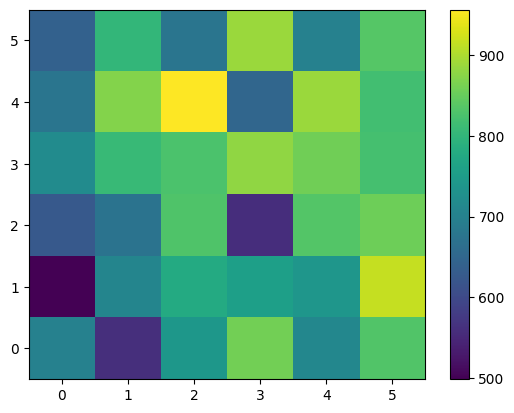

In [53]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [54]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [55]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           34.9
    CT WMD       28.5 ( 27.7 - 29.3 )           26.8
   CT BOTH       47.4 ( 44.5 - 50.5 )           50.0
   CT NONE        8.2 (  8.0 -  8.4 )            7.0
   MRI SBI       31.2 ( 28.0 - 34.6 )           15.0
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.0
  MRI BOTH       34.5 ( 30.6 - 38.7 )           28.2
  MRI NONE        4.8 (  4.5 -  5.2 )            5.0


In [56]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.0
    CT WMD       37.7 ( 36.7 - 38.7 )           10.9
   CT BOTH       51.6 ( 48.3 - 55.1 )           24.4
   CT NONE        6.7 (  6.5 -  6.9 )            2.3
   MRI SBI       16.6 ( 14.2 - 19.3 )            1.7
   MRI WMD        9.6 (  9.1 - 10.1 )            3.3
  MRI BOTH       19.1 ( 16.2 - 22.4 )            6.6
  MRI NONE        2.9 (  2.7 -  3.3 )            1.0


In [57]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           35.0
    CT WMD           22.7
   CT BOTH           40.3
   CT NONE            6.9
   MRI SBI           15.9
   MRI WMD           13.1
  MRI BOTH           25.0
  MRI NONE            6.4


In [58]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           45.6
    CT WMD       63.8 ( 62.6 - 65.1 )           52.3
   CT BOTH       84.9 ( 80.9 - 89.2 )          101.8
   CT NONE       18.2 ( 17.8 - 18.5 )           19.1
   MRI SBI       49.2 ( 45.1 - 53.6 )           24.0
   MRI WMD       28.5 ( 27.6 - 29.4 )           31.9
  MRI BOTH       53.7 ( 48.8 - 59.0 )           64.9
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.2


In [59]:
def get_rates_from_models(x):
    
    ascvdScalingMriSbi = x[0]
        
    nonCvDeathScalingCtSbi = 0.64
    nonCvDeathScalingCtWmh = 0.01
    
    ascvdScalingCtWmh = 1.8
    ascvdScalingCtSbi = 3.8
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = 0
    dementiaQuadraticChange = 0
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                    scdTerm = ascvdScalingMriSbi * scdTerm
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += ascvdScalingCtWmh * np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        def get_scd_term(self, person):
            scdTerm = 0.
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
                if person._modality == Modality.CT.value:
                    scdTerm = nonCvDeathScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if person._modality == Modality.MR.value:
                    scdTerm += np.log(1.645 - 0.0068653 * person._age[-1])
                elif person._modality == Modality.CT.value:
                    scdTerm += nonCvDeathScalingCtWmh * np.log(1.865 - 0.0081088 * person._age[-1])
                else:
                    raise RuntimeError("Person has WMH but no modality")
            return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [60]:
%%time
# step 5, stroke only, mri sbi 
result = optimize.brute(get_loss_from_models, [ (2, 5.) ], 
                        Ns=6, args=(5), finish=None, workers=1, full_output=True ) 

CPU times: user 2h 48min 26s, sys: 3min 19s, total: 2h 51min 45s
Wall time: 2h 50min 45s


In [61]:
result

(2.6,
 1.068059896692166,
 array([2. , 2.6, 3.2, 3.8, 4.4, 5. ]),
 array([103.70400797,   1.0680599 ,   9.81160643,   7.13895388,
         42.54196173,  67.84190438]))

In [62]:
rates = get_rates_from_models([result[0]])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [63]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           34.8
    CT WMD       28.5 ( 27.7 - 29.3 )           27.0
   CT BOTH       47.4 ( 44.5 - 50.5 )           53.3
   CT NONE        8.2 (  8.0 -  8.4 )            6.9
   MRI SBI       31.2 ( 28.0 - 34.6 )           28.9
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.5
  MRI BOTH       34.5 ( 30.6 - 38.7 )           37.7
  MRI NONE        4.8 (  4.5 -  5.2 )            5.0


In [64]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.3
    CT WMD       37.7 ( 36.7 - 38.7 )           10.7
   CT BOTH       51.6 ( 48.3 - 55.1 )           19.4
   CT NONE        6.7 (  6.5 -  6.9 )            2.3
   MRI SBI       16.6 ( 14.2 - 19.3 )            2.2
   MRI WMD        9.6 (  9.1 - 10.1 )            3.4
  MRI BOTH       19.1 ( 16.2 - 22.4 )            6.3
  MRI NONE        2.9 (  2.7 -  3.3 )            1.0


In [65]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           36.0
    CT WMD           23.2
   CT BOTH           40.8
   CT NONE            6.8
   MRI SBI           36.3
   MRI WMD           13.2
  MRI BOTH           41.3
  MRI NONE            5.9


In [66]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           46.9
    CT WMD       63.8 ( 62.6 - 65.1 )           52.7
   CT BOTH       84.9 ( 80.9 - 89.2 )          102.5
   CT NONE       18.2 ( 17.8 - 18.5 )           18.9
   MRI SBI       49.2 ( 45.1 - 53.6 )           35.1
   MRI WMD       28.5 ( 27.6 - 29.4 )           32.1
  MRI BOTH       53.7 ( 48.8 - 59.0 )           63.2
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.3


In [67]:
def get_rates_from_models(x):
    
    nonCvDeathScalingMriSbi = x[0]
    nonCvDeathScalingMriWmh = x[1]
        
    ascvdScalingMriSbi = 2.6
        
    nonCvDeathScalingCtSbi = 0.64
    nonCvDeathScalingCtWmh = 0.01
    
    ascvdScalingCtWmh = 1.8
    ascvdScalingCtSbi = 3.8
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = 0
    dementiaQuadraticChange = 0
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                    scdTerm = ascvdScalingMriSbi * scdTerm
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += ascvdScalingCtWmh * np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        def get_scd_term(self, person):
            scdTerm = 0.
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
                if person._modality == Modality.CT.value:
                    scdTerm = nonCvDeathScalingCtSbi * scdTerm
                elif person._modality == Modality.MR.value:
                    scdTerm = nonCvDeathScalingMriSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if person._modality == Modality.MR.value:
                    scdTerm += nonCvDeathScalingMriWmh * np.log(1.645 - 0.0068653 * person._age[-1])
                elif person._modality == Modality.CT.value:
                    scdTerm += nonCvDeathScalingCtWmh * np.log(1.865 - 0.0081088 * person._age[-1])
                else:
                    raise RuntimeError("Person has WMH but no modality")
            return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [68]:
%%time
# step 6, death only, mri 
result = optimize.brute(get_loss_from_models, [ (0.9, 3.), (0., 1.)], 
                        Ns=7, args=(6), finish=None, workers=1, full_output=True ) 

CPU times: user 23h 11min 45s, sys: 22min 32s, total: 23h 34min 17s
Wall time: 23h 25min 11s


In [69]:
result[0]

array([1.25      , 0.16666667])

In [70]:
result

(array([1.25      , 0.16666667]),
 161.03727796090578,
 array([[[0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
          0.9       , 0.9       ],
         [1.25      , 1.25      , 1.25      , 1.25      , 1.25      ,
          1.25      , 1.25      ],
         [1.6       , 1.6       , 1.6       , 1.6       , 1.6       ,
          1.6       , 1.6       ],
         [1.95      , 1.95      , 1.95      , 1.95      , 1.95      ,
          1.95      , 1.95      ],
         [2.3       , 2.3       , 2.3       , 2.3       , 2.3       ,
          2.3       , 2.3       ],
         [2.65      , 2.65      , 2.65      , 2.65      , 2.65      ,
          2.65      , 2.65      ],
         [3.        , 3.        , 3.        , 3.        , 3.        ,
          3.        , 3.        ]],
 
        [[0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
          0.83333333, 1.        ],
         [0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
          0.83333333, 1.        

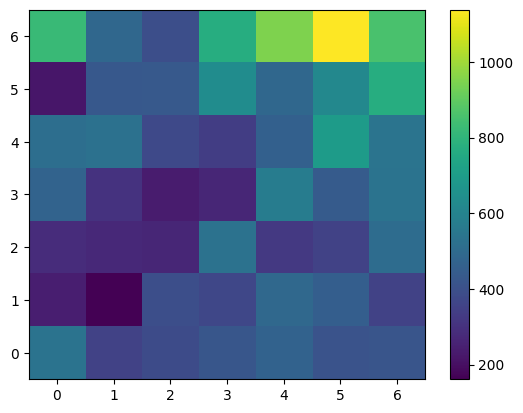

In [71]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [72]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [73]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           36.4
    CT WMD       28.5 ( 27.7 - 29.3 )           27.5
   CT BOTH       47.4 ( 44.5 - 50.5 )           53.9
   CT NONE        8.2 (  8.0 -  8.4 )            7.0
   MRI SBI       31.2 ( 28.0 - 34.6 )           24.6
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.4
  MRI BOTH       34.5 ( 30.6 - 38.7 )           37.8
  MRI NONE        4.8 (  4.5 -  5.2 )            5.1


In [74]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )            5.0
    CT WMD       37.7 ( 36.7 - 38.7 )           11.0
   CT BOTH       51.6 ( 48.3 - 55.1 )           23.0
   CT NONE        6.7 (  6.5 -  6.9 )            2.3
   MRI SBI       16.6 ( 14.2 - 19.3 )            2.0
   MRI WMD        9.6 (  9.1 - 10.1 )            3.3
  MRI BOTH       19.1 ( 16.2 - 22.4 )            9.2
  MRI NONE        2.9 (  2.7 -  3.3 )            1.0


In [75]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           34.6
    CT WMD           23.6
   CT BOTH           40.1
   CT NONE            6.9
   MRI SBI           35.0
   MRI WMD           13.0
  MRI BOTH           39.9
  MRI NONE            6.2


In [76]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           46.4
    CT WMD       63.8 ( 62.6 - 65.1 )           52.6
   CT BOTH       84.9 ( 80.9 - 89.2 )          100.8
   CT NONE       18.2 ( 17.8 - 18.5 )           19.1
   MRI SBI       49.2 ( 45.1 - 53.6 )           33.8
   MRI WMD       28.5 ( 27.6 - 29.4 )           29.3
  MRI BOTH       53.7 ( 48.8 - 59.0 )           68.2
  MRI NONE       14.0 ( 13.4 - 14.6 )           13.7


In [77]:
def get_rates_from_models(x):
    
    nonCvDeathScalingMriSbi = 1.25
    nonCvDeathScalingMriWmh = 0.1667
        
    ascvdScalingMriSbi = 2.6
        
    nonCvDeathScalingCtSbi = 0.64
    nonCvDeathScalingCtWmh = 0.01
    
    ascvdScalingCtWmh = 1.8
    ascvdScalingCtSbi = 3.8
    
    ascvdInterceptChange = 0.645 
    dementiaLinearChange = x[0]
    dementiaQuadraticChange = x[1]
    nonCVDeathInterceptChange = 0.35
    
    def get_scd_term(person):
            '''This is the contribution to the one year linear predictor due to the silent cerebrovascular disease (scd).'''
            scdTerm = 0
            window = len(person._age)
            severityUnknown=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverityUnknown", inSim=True),
            severity=person.get_outcome_item_first(OutcomeType.WMH, "wmhSeverity", inSim=True)
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                if person._modality == Modality.MR.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(4.75)
                        elif window <=3:
                            scdTerm += np.log(3.45)
                        elif window <=5:
                            scdTerm += np.log(2.18)
                        elif window >5:
                            scdTerm += np.log(1.99)
                    else:
                        if window ==1:
                            scdTerm += np.log(3.)
                        elif window <=3:
                            scdTerm += np.log(2.63)
                        elif window <=5:
                            scdTerm += np.log(1.61)
                        elif window >5:
                            scdTerm += np.log(1.43)
                    scdTerm = ascvdScalingMriSbi * scdTerm
                elif person._modality == Modality.CT.value:
                    if person._age[-1] < 65:
                        if window ==1:
                            scdTerm += np.log(3.91)
                        elif window <=3:
                            scdTerm += np.log(2.34)
                        elif window <=5:
                            scdTerm += np.log(2.33)
                        elif window >5:
                            scdTerm += np.log(2.01)
                    else:
                        if window ==1:
                            scdTerm += np.log(2.47)
                        elif window <=3:
                            scdTerm += np.log(1.79)
                        elif window <=5:
                            scdTerm += np.log(1.71)
                        elif window >5:
                            scdTerm += np.log(1.44)
                    scdTerm = ascvdScalingCtSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if window ==1:
                    td = 1.
                    #        lp += np.log(1.89)
                elif window <=3:
                    #td = 1.9/1.89
                    td = np.log(1.9)/np.log(1.89)
                    #        lp += np.log(1.90)
                elif window <=5:
                    #td = 1.73/1.89
                    td = np.log(1.73)/np.log(1.89)
                    #        lp += np.log(1.73)
                elif window >5:
                    #td = 1.56/1.89
                    td = np.log(1.56)/np.log(1.89)
                    #        lp += np.log(1.56)
                td = 1 #let's see the best we can do without time dependency
                if person._modality == Modality.MR.value:
                    if severityUnknown:
                        scdTerm += np.log(td*1.89)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += np.log(td*1.51)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += np.log(td*2.33)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += np.log(td*2.65)
                    elif severity == WMHSeverity.NO:
                        scdTerm += np.log(td*1.)
                elif person._modality == Modality.CT.value:
                    if severityUnknown:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.40)
                    elif severity == WMHSeverity.MILD:
                        scdTerm += ascvdScalingCtWmh * np.log(td*2.15)
                    elif severity == WMHSeverity.MODERATE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.01)
                    elif severity == WMHSeverity.SEVERE:
                        scdTerm += ascvdScalingCtWmh * np.log(td*3.23)
                    elif severity == WMHSeverity.NO:
                        scdTerm += ascvdScalingCtWmh * np.log(td*1.39)
            return scdTerm
    
    # these will replace the CV models that microsim uses by default
    interceptM = -11.679980 + ascvdInterceptChange
    interceptF =  -12.823110 + ascvdInterceptChange
    class CVModelMaleKaiser(CVModelMale):
        def __init__(self, intercept=interceptM):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    class CVModelFemaleKaiser(CVModelFemale):
        def __init__(self, intercept=interceptF):
            super().__init__(intercept = intercept)
            
        def get_one_year_linear_predictor(self, person, interceptChangeFor1bpMedsAdded=0):
            lp = super().get_one_year_linear_predictor(person, interceptChangeFor1bpMedsAdded)
            lp += get_scd_term(person)
            return lp

    import importlib.util
    module = importlib.import_module("microsim.cv_model_repository")
    setattr(module, "CVModelMale", CVModelMaleKaiser)
    setattr(module, "CVModelFemale", CVModelFemaleKaiser)
    
    class DementiaModelRepositoryKaiser(DementiaModelRepository):
        def __init__(self):
            self._models = {"NHANES": DementiaModel(), #default linear and quadratic terms for NHANES
                            "brainScan": DementiaModel(linearTerm= 1.33371239e-05 +dementiaLinearChange, 
                                                       quadraticTerm= 5.64485841e-05 +dementiaQuadraticChange)} #had a brain scan
        
    module = importlib.import_module("microsim.outcome_model_repository")
    setattr(module, "DementiaModelRepository", DementiaModelRepositoryKaiser)
    
    class NonCVDeathModelKaiser(StatsModelLogisticRiskFactorModel):
        def __init__(self):
            modelSpec = load_model_spec("nhanesMortalityModelLogit")
            # Recalibrate mortalitly model to align with life table data, as explored in notebook buildNHANESMortalityModel
            modelSpec["coefficients"]["age"] = modelSpec["coefficients"]["age"]*(-1)
            modelSpec["coefficients"]["squareAge"] = modelSpec["coefficients"]["squareAge"]*4 
            modelSpec["coefficients"]["Intercept"] += nonCVDeathInterceptChange
            super().__init__(RegressionModel(**modelSpec), False)

        def generate_next_outcome(self, person):
            fatal=True
            selfReported = False
            return Outcome(OutcomeType.NONCARDIOVASCULAR, fatal, selfReported)

        def get_next_outcome(self, person):
            #need to find a better way to check for mortality during current age outcomes
            if person.has_fatal_outcome_at_current_age(OutcomeType.CARDIOVASCULAR):
                return None
            else:
                #if person._rng.uniform(size=1)<self.get_risk_for_person(person, person._rng, 1):
                if person._rng.uniform(size=1)<self.estimate_next_risk(person):
                    return self.generate_next_outcome(person) 
                else:
                    return None
                
        def get_scd_term(self, person):
            scdTerm = 0.
            if person._outcomes[OutcomeType.WMH][0][1].sbi:
                scdTerm += np.log(1.76 - 0.007513 * person._age[-1])
                if person._modality == Modality.CT.value:
                    scdTerm = nonCvDeathScalingCtSbi * scdTerm
                elif person._modality == Modality.MR.value:
                    scdTerm = nonCvDeathScalingMriSbi * scdTerm
            if person._outcomes[OutcomeType.WMH][0][1].wmh:
                if person._modality == Modality.MR.value:
                    scdTerm += nonCvDeathScalingMriWmh * np.log(1.645 - 0.0068653 * person._age[-1])
                elif person._modality == Modality.CT.value:
                    scdTerm += nonCvDeathScalingCtWmh * np.log(1.865 - 0.0081088 * person._age[-1])
                else:
                    raise RuntimeError("Person has WMH but no modality")
            return scdTerm
        
        def estimate_linear_predictor(self, person):
            lp = super().estimate_linear_predictor(person)
            lp += self.get_scd_term(person)
            return lp
    
    module = importlib.import_module("microsim.non_cv_model_repository")
    setattr(module, "NonCVDeathModel", NonCVDeathModelKaiser)
    
    popSize = 400000
    duration=4
    pop = PopulationFactory.get_kaiser_population(n=popSize)
    pop.advance(duration, nWorkers=1)
    
    strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], 
                                                                                     wave=duration-1)
    dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], 
                                                                                       wave=duration-1)
    deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], 
                                                                                    wave=duration-1)
    miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], 
                                                                                     wave=duration-1)
    return {"stroke": strokeRates, "dementia": dementiaRates, "death": deathRates, "mi": miRates}

In [78]:
%%time
# step 7, dementia only 
result = optimize.brute(get_loss_from_models, [ (1e-4, 6e-4), (0.4e-6, 6e-5)], 
                        Ns=8, args=(7), finish=None, workers=1, full_output=True ) 

CPU times: user 1d 6h 26min 51s, sys: 36min 27s, total: 1d 7h 3min 19s
Wall time: 1d 6h 55min 6s


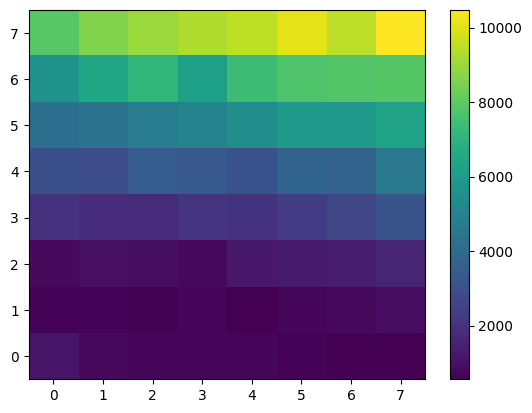

In [79]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [80]:
result[0]

array([1.00000000e-04, 5.14857143e-05])

In [81]:
result[3]

array([[ 1140.41003212,   814.93039761,   717.97980986,   727.82144994,
          697.82956487,   667.29968541,   560.59888325,   593.19106724],
       [  645.401189  ,   660.28148101,   607.91449989,   683.4904147 ,
          567.33394231,   729.316442  ,   777.52902515,   903.00985733],
       [  797.6876992 ,   957.51769604,   921.9909318 ,   788.65727849,
         1257.8444099 ,  1293.13175533,  1396.88420909,  1570.44049745],
       [ 1965.71660058,  1817.11848804,  1766.74698906,  2084.1374957 ,
         2011.75414261,  2309.54820113,  2644.78478577,  3108.41147455],
       [ 2993.49781202,  2895.71102859,  3450.87047799,  3288.17530743,
         3067.28946061,  3776.0120029 ,  3731.63445958,  4520.56381427],
       [ 4186.51018268,  4326.43792662,  4773.00386291,  4981.86291402,
         5444.70600483,  5883.64887863,  5890.35646336,  6289.32564385],
       [ 5640.66403196,  6466.21834053,  7107.0085863 ,  6211.11398543,
         7349.49121707,  7741.20651261,  7812.07900007,  7

In [82]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [83]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

     Group                  Reference     Simulation
    CT SBI       36.6 ( 34.9 - 38.4 )           36.6
    CT WMD       28.5 ( 27.7 - 29.3 )           27.0
   CT BOTH       47.4 ( 44.5 - 50.5 )           50.7
   CT NONE        8.2 (  8.0 -  8.4 )            7.1
   MRI SBI       31.2 ( 28.0 - 34.6 )           28.2
   MRI WMD       13.0 ( 12.4 - 13.6 )           12.6
  MRI BOTH       34.5 ( 30.6 - 38.7 )           37.6
  MRI NONE        4.8 (  4.5 -  5.2 )            4.8


In [84]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       32.8 ( 31.0 - 34.6 )           14.5
    CT WMD       37.7 ( 36.7 - 38.7 )           28.4
   CT BOTH       51.6 ( 48.3 - 55.1 )           59.8
   CT NONE        6.7 (  6.5 -  6.9 )            6.4
   MRI SBI       16.6 ( 14.2 - 19.3 )            6.5
   MRI WMD        9.6 (  9.1 - 10.1 )            8.4
  MRI BOTH       19.1 ( 16.2 - 22.4 )           21.8
  MRI NONE        2.9 (  2.7 -  3.3 )            2.5


In [85]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

     Group     Simulation
    CT SBI           36.1
    CT WMD           23.5
   CT BOTH           43.3
   CT NONE            6.9
   MRI SBI           33.4
   MRI WMD           12.9
  MRI BOTH           40.0
  MRI NONE            6.1


In [86]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)

     Group                  Reference     Simulation
    CT SBI       61.5 ( 59.1 - 63.9 )           47.8
    CT WMD       63.8 ( 62.6 - 65.1 )           52.7
   CT BOTH       84.9 ( 80.9 - 89.2 )          102.0
   CT NONE       18.2 ( 17.8 - 18.5 )           19.3
   MRI SBI       49.2 ( 45.1 - 53.6 )           32.7
   MRI WMD       28.5 ( 27.6 - 29.4 )           29.6
  MRI BOTH       53.7 ( 48.8 - 59.0 )           63.8
  MRI NONE       14.0 ( 13.4 - 14.6 )           12.9


In [ ]:
%%time
#step 3, mri sbi only,  stroke and death
result = optimize.brute(get_loss_from_models, [ (2., 12.), (1., 7.0)], 
                        Ns=8, args=(3), finish=None, workers=1, full_output=True ) 

In [ ]:
plt.imshow(result[3], cmap='viridis', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
rates = get_rates_from_models(result[0])
strokeRates = rates["stroke"]
dementiaRates = rates["dementia"]
miRates = rates["mi"]
deathRates = rates["death"]

In [ ]:
strokeRatesRef = {1: 36.6, 2: 28.5, 3: 47.4, 0: 8.2, 5:31.2, 6: 13.,  7:34.5, 4: 4.8}
strokeMinCiRef = {1: 34.9, 2: 27.7, 3: 44.5, 0: 8.,  5:28.,  6: 12.4, 7:30.6, 4: 4.5}
strokeMaxCiRef = {1: 38.4, 2: 29.3, 3: 50.5, 0: 8.4, 5:34.6, 6: 13.6, 7:38.7, 4: 5.2}
groupStrings = {1:"CT SBI", 2: "CT WMD", 3: "CT BOTH", 0: "CT NONE", 5:"MRI SBI", 6:"MRI WMD", 7:"MRI BOTH", 4:"MRI NONE"}
#strokeRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.STROKE], wave=3)
strokeRatesList = list()
print("     Group                  Reference     Simulation")
for group in strokeRatesRef.keys():
    strokeRatesList += [ [f"{groupStrings[group]:10} ", 
                                f"{strokeRatesRef[group]:>4.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) ",
                                f"{strokeRates[group]:<4.1f}" ] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{strokeRatesRef[group]:>10.1f} ({strokeMinCiRef[group]:>5.1f} - {strokeMaxCiRef[group]:>4.1f} ) " +
          f"{strokeRates[group]:>14.1f}")
strokeRatesPd = pd.DataFrame(strokeRatesList, columns=["Group", "Reference", "Simulation"])        
strokeRatesPd.to_csv(dataDir+"/kaiserStrokeValidation4YrRates.csv", index=False)
#strokeRatesPd

In [ ]:
dementiaRatesRef = {1:32.8, 2:37.7, 3:51.6, 0:6.7, 5:16.6, 6:9.6, 7:19.1, 4:2.9}
dementiaMinCiRef = {1:31.,  2:36.7, 3:48.3, 0:6.5, 5:14.2, 6:9.1, 7:16.2, 4:2.7}
dementiaMaxCiRef = {1:34.6, 2:38.7, 3:55.1, 0:6.9, 5:19.3, 6:10.1,7:22.4, 4:3.3}
#dementiaRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEMENTIA], wave=3)
dementiaRatesList = list()
print("     Group                  Reference     Simulation")
for group in dementiaRatesRef.keys():
    dementiaRatesList += [ [f"{groupStrings[group]:>10} ", 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) ",
          f"{dementiaRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{dementiaRatesRef[group]:>10.1f} ({dementiaMinCiRef[group]:>5.1f} - {dementiaMaxCiRef[group]:>4.1f} ) " +
          f"{dementiaRates[group]:>14.1f}")
dementiaRatesPd = pd.DataFrame(dementiaRatesList, columns=["Group", "Reference", "Simulation"])        
dementiaRatesPd.to_csv(dataDir+"/kaiserDementiaValidation4YrRates.csv", index=False)

In [ ]:
#miRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.MI], wave=3)
#print("     Group                  Reference     Simulation")
print("     Group     Simulation")
miRatesList = list()
for group in groupStrings.keys():
    miRatesList += [ [f"{groupStrings[group]:>10} ",  
                      f"{miRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{miRates[group]:>14.1f}")
miRatesPd = pd.DataFrame(miRatesList, columns=["Group", "Simulation"])        
miRatesPd.to_csv(dataDir+"/kaiserMiValidation4YrRates.csv", index=False)

In [ ]:
deathRatesRef = {1:61.5, 2: 63.8, 3: 84.9, 0:18.2, 5:49.2, 6:28.5, 7:53.7, 4:14.}
deathMinCiRef = {1:59.1, 2:62.6,  3: 80.9, 0:17.8, 5:45.1, 6:27.6, 7:48.8, 4:13.4}
deathMaxCiRef = {1:63.9, 2:65.1,  3:89.2,  0:18.5, 5:53.6, 6:29.4, 7:59.0, 4:14.6}
#deathRates = pop.get_outcome_incidence_rates_by_scd_and_modality_at_end_of_wave(outcomesTypeList=[OutcomeType.DEATH], wave=3)
deathRatesList = list()
print("     Group                  Reference     Simulation")
for group in deathRatesRef.keys():
    deathRatesList += [ [f"{groupStrings[group]:>10} ", 
                         f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) ",
                         f"{deathRates[group]:>14.1f}"] ]
    print(f"{groupStrings[group]:>10} " + 
          f"{deathRatesRef[group]:>10.1f} ({deathMinCiRef[group]:>5.1f} - {deathMaxCiRef[group]:>4.1f} ) " +
          f"{deathRates[group]:>14.1f}")
deathRatesPd = pd.DataFrame(deathRatesList, columns=["Group", "Reference", "Simulation"])        
deathRatesPd.to_csv(dataDir+"/kaiserDeathValidation4YrRates.csv", index=False)